# 文本分类

	本次实践将使用Python语言结合paddlepaddle深度学习框架，创建卷积神经网络实现新闻标题的分类模型。

    数据来源：从网站上爬取56821条数据中文新闻摘要

    数据内容：包含10种类别，国际、文化、娱乐、体育、财经、汽车、教育、科技、房产、证券
![](https://ai-studio-static-online.cdn.bcebos.com/1789ed5939d24134b9ce4d45ca15e0fdf21f25aa400c4f6898cc4e02aea5c74e)

# **1、准备数据:**

    创建数据集和数据字典

    创建数据读取器train_reader 和test_reader

# **2、配置网络**

定义网络

定义损失函数

定义优化算法

# **3、训练网络**

# **4、模型评估**

# **5、模型预测**


In [1]:
# 查看当前挂载的数据集目录
!ls /home/aistudio/data/
#将数据移动到 /home/aistudio/data/ 目录下
!cp data/data6825/news_classify_data.txt data/

data6825  dict_txt.txt	news_classify_data.txt	test_list.txt  train_list.txt


In [1]:
# 导入必要的包
import os
from multiprocessing import cpu_count
import numpy as np
import shutil
import paddle
import paddle.fluid as fluid
import matplotlib.pyplot as plt

d:\python高级程序设计\.venv\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [4]:
train_file = 'work/shuffle_Train_IDs.txt'
dic_file = 'work/dict.txt'
val_file = 'work/Val_IDs.txt'

In [18]:
# 定义新闻类别
classes = {0: '财经',
 1: '彩票',
 2: '房产',
 3: '股票',
 4: '家居',
 5: '教育',
 6: '科技',
 7: '社会',
 8: '时尚',
 9: '时政',
 10: '体育',
 11: '星座',
 12: '游戏',
 13: '娱乐'}

In [5]:
# 创建数据字典
def load_dic(dic_file):
    # 加载字典
    word2id_dic = dict()
    with open(dic_file,'r',encoding='utf-8') as f:
        text = f.read()
        word2id_dic = eval(text)
    # 获取未编码数字id
    word2id_dic['<pad>'] = len(word2id_dic) # 表示非定长数据的填充
    return word2id_dic

word2id_dic = load_dic(dic_file)

In [6]:
# 通过id，索引文字的数据字典
id2word_dic = {}
for key,values in word2id_dic.items():
    id2word_dic[values] = key

In [8]:
# 定义数据集加载函数
def load_dataset(data_file):
    data_set = []
    with open(data_file,'r',encoding='utf-8') as f:
        for line in f.readlines():
            line = line[:-1]
            sample = line.split('\t')
            sample[0] = sample[0].split(',')
            if len(sample[0]) < 1:
                print('数据长度错误')
                continue
            sample[0] = [int(x) for x in sample[0]]
            data_set.append((sample[0],int(sample[1])))
    return data_set
train_set = load_dataset(train_file)

In [12]:
# 创建train_reader
def train_reader():
    np.random.shuffle(train_set)
    for i in train_set:
        yield i

In [27]:
# 创建test_reader
def test_reader():
    test_set = load_dataset(val_file)
    np.random.shuffle(test_set)
    for i in test_set:
        yield i

# 卷积神经网络（Convolutional Neural Networks, CNN）

输入词向量序列，产生一个特征图（feature map），对特征图采用时间维度上的最大池化（max pooling over time）操作得到此卷积核对应的整句话的特征，最后，将所有卷积核得到的特征拼接起来即为文本的定长向量表示，对于文本分类问题，将其连接至softmax即构建出完整的模型。

在实际应用中，我们会使用多个卷积核来处理句子，窗口大小相同的卷积核堆叠起来形成一个矩阵，这样可以更高效的完成运算。

另外，我们也可使用窗口大小不同的卷积核来处理句子.

![](https://ai-studio-static-online.cdn.bcebos.com/3766261f24b54514b6cbc0d30270c6a3f38c1d0aaf8f450c97e8303eca51f204)

In [15]:
# 定义CNN，
def convolution_net(data,input_dim,class_dim ,emb_dim , hid_dim = 128, hid_dim2= 128):
    emb = fluid.layers.embedding(
        input = data,size=[input_dim,emb_dim],is_sparse=True
    )
    print('emb shape : ',emb.shape)
    con_3 = fluid.nets.sequence_conv_pool(
        input= emb,
        num_filters=hid_dim,
        filter_size=3,
        act='tanh',
        pool_type='sqrt'
    )
    print('con3 shape ',con_3.shape)
    con_4 = fluid.nets.sequence_conv_pool(
        input= emb,
        num_filters=hid_dim2,
        filter_size=4,
        act='tanh',
        pool_type='sqrt'
    )
    print('con4 shape ',con_4.shape)
    prediction = fluid.layers.fc(
        input = [con_3,con_4],size=class_dim,act='softmax'
    )

    return prediction

In [17]:
paddle.enable_static()

In [19]:
# 定义超参数
dict_dim = len(word2id_dic)
embed_dim = 128
class_dim = len(classes)

In [20]:
words = fluid.layers.data(
    name='words',shape=[1],dtype='int64',lod_level=1
)
def inference_program(word_dic):
    dict_dim = len(word2id_dic)
    net = convolution_net(words,dict_dim,class_dim=class_dim,emb_dim=embed_dim)
    return net

In [21]:
def train_program(prediction):
    label = fluid.layers.data(
        name = 'label',shape=[1],dtype='int64'
    )
    cost = fluid.layers.cross_entropy(input=prediction,label=label)
    avg_cost = fluid.layers.mean(cost)
    acc = fluid.layers.accuracy(input= prediction,label=label)
    return [avg_cost,acc]

In [23]:
def optimizer_func():
    return fluid.optimizer.Adam(learning_rate=0.002)

In [24]:
use_cuda = False  #在cpu上进行训练
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)

In [25]:
prediction = inference_program('data/dict_txt.txt')
[avg_cost,acc] = train_program(prediction)


emb shape :  (-1, 128)
con3 shape  (-1, 128)
con4 shape  (-1, 128)


In [26]:
optimizer = optimizer_func()
optimizer.minimize(avg_cost)

([{Beta1PowOut=['embedding_0.w_0_beta1_pow_acc_0'], Beta2PowOut=['embedding_0.w_0_beta2_pow_acc_0'], Moment1Out=['embedding_0.w_0_moment1_0'], Moment2Out=['embedding_0.w_0_moment2_0'], ParamOut=['embedding_0.w_0']} = adam(inputs={Beta1Pow=['embedding_0.w_0_beta1_pow_acc_0'], Beta1Tensor=[], Beta2Pow=['embedding_0.w_0_beta2_pow_acc_0'], Beta2Tensor=[], Grad=['embedding_0.w_0@GRAD'], LearningRate=['learning_rate_0'], MasterParam=[], Moment1=['embedding_0.w_0_moment1_0'], Moment2=['embedding_0.w_0_moment2_0'], Param=['embedding_0.w_0']}, beta1 = 0.8999999761581421, beta2 = 0.9990000128746033, epsilon = 9.99999993922529e-09, lazy_mode = False, min_row_size_to_use_multithread = 1000, multi_precision = False, op_device = , op_namescope = /optimizer/, op_role = 2, op_role_var = ['embedding_0.w_0', 'embedding_0.w_0@GRAD']),
  {Beta1PowOut=['fc_0.b_0_beta1_pow_acc_0'], Beta2PowOut=['fc_0.b_0_beta2_pow_acc_0'], Moment1Out=['fc_0.b_0_moment1_0'], Moment2Out=['fc_0.b_0_moment2_0'], ParamOut=['fc_0

In [29]:
# 获取训练数据读取器和测试数据读取器
BATCH_SIZE =128
train_reader = paddle.batch(reader=train_reader, batch_size=BATCH_SIZE)
test_reader = paddle.batch(reader=test_reader, batch_size=BATCH_SIZE)

In [30]:
sampledata = next(train_reader())
print(sampledata[0])

([2830, 2567, 1472, 3222, 4632, 3200, 389, 690, 3951, 3967, 2983, 5072, 2886, 690, 1006, 4289, 3314, 1230, 5276, 4141, 1264], 10)


In [31]:
# 定义数据映射器
feeder = fluid.DataFeeder(place=place, feed_list=['words','label'])

In [34]:
#参数初始化
exe.run(fluid.default_startup_program())

[]

In [35]:
test_program = fluid.default_main_program().clone(for_test=True)

In [36]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)

    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)

    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    
    plt.show()

In [37]:
EPOCH_NUM=5
model_save_dir = 'work/infer_model/'
# 开始训练

for pass_id in range(EPOCH_NUM):
    # 进行训练
    for batch_id, data in enumerate(train_reader()):
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),
                             feed=feeder.feed(data),
                             fetch_list=[avg_cost, acc])
        all_train_iter=all_train_iter+BATCH_SIZE #0,128,...
        all_train_iters.append(all_train_iter) #
        all_train_costs.append(train_cost[0]) #每个batch训练后的均方误差
        all_train_accs.append(train_acc[0]) #每个batch训练后的准确率，因为数据平衡，所以主要评估acc，
        
        if batch_id % 100 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Acc:%0.5f' % (pass_id, batch_id, train_cost[0], train_acc[0]))
    # 进行测试
    test_costs = []
    test_accs = []
    for batch_id, data in enumerate(test_reader()):
        test_cost, test_acc = exe.run(program=test_program,
                                              feed=feeder.feed(data),
                                              fetch_list=[avg_cost,acc])
        test_costs.append(test_cost[0])
        test_accs.append(test_acc[0])
    # 计算平均预测损失在和准确率
    test_cost = (sum(test_costs) / len(test_costs))
    test_acc = (sum(test_accs) / len(test_accs))
    print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, test_cost, test_acc))



Pass:0, Batch:0, Cost:2.64438, Acc:0.04688
Pass:0, Batch:100, Cost:0.52839, Acc:0.82031
Pass:0, Batch:200, Cost:0.50471, Acc:0.82812
Pass:0, Batch:300, Cost:0.58335, Acc:0.81250
Pass:0, Batch:400, Cost:0.53429, Acc:0.84375
Pass:0, Batch:500, Cost:0.54593, Acc:0.82031
Pass:0, Batch:600, Cost:0.43220, Acc:0.87500
Pass:0, Batch:700, Cost:0.61883, Acc:0.75000
Pass:0, Batch:800, Cost:0.36697, Acc:0.89062
Pass:0, Batch:900, Cost:0.28341, Acc:0.89844
Pass:0, Batch:1000, Cost:0.55198, Acc:0.84375
Pass:0, Batch:1100, Cost:0.34354, Acc:0.90625
Pass:0, Batch:1200, Cost:0.26559, Acc:0.92188
Pass:0, Batch:1300, Cost:0.39640, Acc:0.87500
Pass:0, Batch:1400, Cost:0.60561, Acc:0.78906
Pass:0, Batch:1500, Cost:0.43641, Acc:0.85938
Pass:0, Batch:1600, Cost:0.34930, Acc:0.86719
Pass:0, Batch:1700, Cost:0.34159, Acc:0.86719
Pass:0, Batch:1800, Cost:0.38901, Acc:0.86719
Pass:0, Batch:1900, Cost:0.44684, Acc:0.86719
Pass:0, Batch:2000, Cost:0.43953, Acc:0.89062


KeyboardInterrupt: 

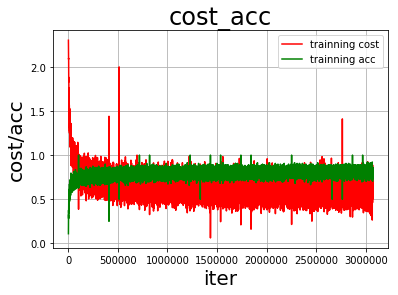

In [28]:
draw_train_process('cost_acc',all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

In [29]:
# 保存预测模型
if not os.path.exists(model_save_dir): 
    os.makedirs(model_save_dir) 
fluid.io.save_inference_model(model_save_dir, 
                            feeded_var_names=['words'], 
                            target_vars=[prediction], 
                            executor=exe)
print('训练模型保存完成！') 

训练模型保存完成！


In [38]:
# 获取数据,将数据转换成编码格式
def get_data(sentence):
    # 把字符串数据转换成列表数据
    keys = word2id_dic.keys()
    data = []
    for s in sentence:
        # 判断是否存在未知字符
        if not s in keys:
            s = '<unk>'
        data.append(word2id_dic[s])
    return data


In [39]:
data = []
# 获取预测数据
data1 = get_data('在获得诺贝尔文学奖7年之后，莫言15日晚间在山西汾阳贾家庄如是说')
data2 = get_data('综合“今日美国”、《世界日报》等当地媒体报道，芝加哥河滨警察局表示，')
data.append(data1)
data.append(data2)
base_shape = [[len(c) for c in data]]
print(base_shape)
tensor_words = fluid.create_lod_tensor(data, base_shape, place)
print(tensor_words)

[[32, 34]]
  - lod: {{0, 32, 66}}
  - place: CPUPlace
  - shape: [66, 1]
  - layout: NCHW
  - dtype: int
  - data: [4401 4162 1839 3844 1139 3967 2567 294 3825 4075 312 4069 2896 1002 3979 898 1521 2050 1094 3983 2033 4401 2681 2573 186 1499 303 12 2787 601 2040 1148 4944 3174 4426 4133 1094 1546 3740 1695 4562 3019 3178 4666 1094 4363 1596 4260 221 643 200 2316 4363 4432 1002 2667 2031 715 1912 454 1978 3253 1003 4221 1831 1002]


In [32]:
# 用训练好的模型进行预测并输出预测结果
# 创建执行器
infer_exe = fluid.Executor(place)    #创建推测用的executor

inference_scope = fluid.core.Scope() #Scope指定作用域

save_path = 'work/infer_model/'

with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。

# 从模型中获取预测程序、输入数据名称列表、分类器
    [infer_program, feeded_var_names, target_var] = fluid.io.load_inference_model(dirname=save_path, executor=exe)

    data = []
    # 获取预测数据
    data1 = get_data('在获得诺贝尔文学奖7年之后，莫言15日晚间在山西汾阳贾家庄如是说')
    data2 = get_data('国际航协：2021年三季度全球航企亏损收窄')
    data.append(data1)
    data.append(data2)
    # print(data)
    # 获取每句话的单词数量
    base_shape = [[len(c) for c in data]]

    # 生成预测数据
    tensor_words = fluid.create_lod_tensor(data, base_shape, place)#data是数据，base_shape用于数据的分割
    # print(tensor_words)
    # 执行预测
    result = infer_exe.run(program=infer_program,
                    feed={feeded_var_names[0]: tensor_words},
                    fetch_list=target_var)
    # 分类名称
    names = [ '文化', '娱乐', '体育', '财经','房产', '汽车', '教育', '科技', '国际', '证券']
    print(np.argsort(result))
    # 获取结果概率最大的label
    for i in range(len(data)):
        lab = np.argsort(result)[0][i][-1]
        print('预测结果标签为：%d， 名称为：%s， 概率为：%f' % (lab, names[lab], result[0][i][lab]))

[[[9 5 4 3 7 2 1 6 8 0]
  [0 1 4 6 2 5 9 7 8 3]]]
预测结果标签为：0， 名称为：文化， 概率为：0.962727
预测结果标签为：3， 名称为：财经， 概率为：0.699406
